# Análise de Padrões de Origem e Destino

**AUTORIA:** [REDE MOB](https://www.redemob.com.br/)

Análise do padrão de viagens de um município com base em dados de pesquisa de origem e destino. As linhas de código abaixo têm como objeto o município de Belo Horizonte, mas serve para qualquer outro, desde que os dados de entrada estejam no layout padrão da Plataforma.

**PANORAMA:**
- #TODO: Listar as análises aqui contidas

**MAIS INFORMAÇÕES:**
- [Layout da Plataforma]
- [Sumário dos Dados Disponíveis]
- *Lorem ipsum: Conteúdo do MOB de interesse, técnico ou de divulgação*

**LINKS DE INTERESSE:**
- links para materiais técnicos e acadêmicos gerais de referência a respeito do conteúdo abordado



# Introdução

Este script foi concebido em caráter de tutorial, tomando como exemplo o município de Belo Horizonte/MG, de forma que as considerações e discussões aqui contidas foram tecidas no contexto dessa municipalidade. Com efeito, procurou-se, na medida do possível, deixar o texto abrangente a ponto de orientar as análises de outros municípios. Ou seja, este script acaba constituindo um apoio para o diagnóstico de outras localidade, na medida em que houve um esforço de trazer técnicas e elementos norteadores para contribuir para o diagnóstico de outros locais. Com efeito, ao alterar os parâmetros de entrada, conforme demonstrado logo abaixo, podem ser gerados mapas e gráficos de territórios distintos. Nesse caso, as considerações originalmente tecidas para Belo Horizonte podem não se aplicar completamente, mas, elas ainda devem fornecer insumos para a interpretação de resultados de outros locais.

# Instruções

**Essas instruções são para o usuário final do script, não para você, Matheus**

Este script precisa de dois grupos de dados:
1. Dados de origem e destino #TODO: explicar como obter
2. Malhas territoriais de zonas de tráfego

Essses dados devem ser atribuídos às variáveis abaixo. Em seguida, deve-se rodar todo o script e os resultados estarão ao final.

In [1]:
from pathlib import Path
cwd = Path.cwd()
data_folder = cwd.parent / 'database/5. Padrão de Viagens/od_rio'

pessoa = data_folder / 'pessoas_od_2012.csv'

domicilio = data_folder / 'domicilios_od_2012.csv'

viagem = data_folder / 'deslocamentos_od_2012.csv'

zonas = data_folder / 'zonas_rj_2012.zip'

# Backend

Verificar as tabelas 

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

hts = pd.read_csv(data_folder / 'od_consolidado_rmrj_2012.csv', index_col=0)
zones = (
    gpd
    .read_file(data_folder / 'zonas_trafego_rj_2012.zip')
    .rename(columns={'Zona_2012': 'zona'})
    .astype({'zona': int})
    )

c:\Users\brand\anaconda3\envs\roda\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


## Divisão Modal

A análise de divisão modal ajuda a visualizar a distribuição dos diferentes modos de transporte utilizados pela população, fundamental para ententeder como as pessoas se movem pela cidade, quais são os meios mais utiliza dos e como essas preferências podem variar de acordo com fatores de renda, localização, disponibilidade de infraestrutura, etc. Esse tipo de análise facilita a leitura dos dados e permite tomadas de decisões que melhore a dinâmica da mobilidade urbana.

In [51]:
def plot_modal_share(df, mode_col, income_col=None, weight_col='fator_expansao'):
    try:
        if income_col:
            modal_share = (
                df.groupby([income_col, mode_col])[weight_col]
                .sum()
                .reset_index(name='count')
            )
            modal_share_pivot = modal_share.pivot(index=income_col, columns=mode_col, values='count').fillna(0)
            modal_share_pivot.div(modal_share_pivot.sum(axis=1), axis=0).plot(kind='bar', stacked=True)
            plt.title('Modal Share by Income Group')
        else:
            modal_share = df.groupby(mode_col)[weight_col].sum()
            (modal_share / modal_share.sum()).plot(kind='bar')
            plt.title('Overall Modal Share')

        plt.ylabel('Share')
        plt.xlabel('')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in plot_modal_share: {e}")

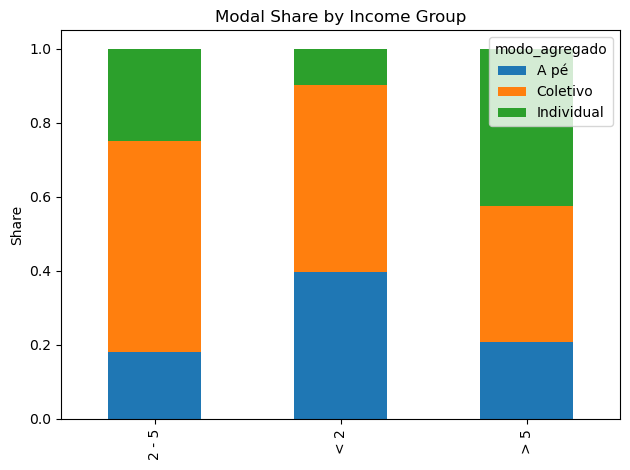

In [52]:
plot_modal_share(hts, 'modo_agregado', 'faixa_renda')

# Análise Temporal

In [53]:
def plot_travel_time_distribution(df, time_col, group_col, weight_col='fator_expansao'):
    try:
        plt.figure(figsize=(10, 6))
        sns.violinplot(
            data=df,
            x=group_col,
            y=time_col,
            hue=group_col,
            inner="quartile",
            palette="viridis",
            legend=False
        )
        plt.title("Distribuição de Tempo de Viagem por Grupo")
        plt.xlabel(group_col)
        plt.ylabel("Tempo de Viagem (min)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in plot_travel_time_distribution: {e}")

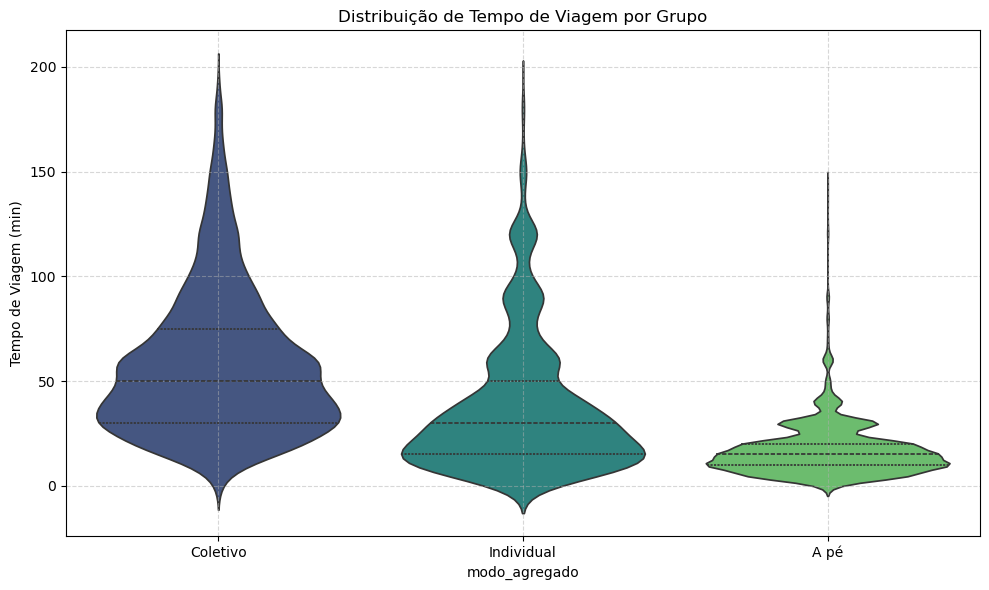

In [54]:
plot_travel_time_distribution(hts, 'tempo_viagem', group_col='modo_agregado') #income_col='faixa_renda')

In [57]:
def plot_cumulative_travel_time(df, time_col, group_col=None, weight_col='fator_expansao'):
    if time_col not in df.columns:
        raise ValueError(f"'{time_col}' not found in DataFrame.")

    try:
        plt.figure(figsize=(10, 6))

        if not group_col or group_col not in df.columns:
            sorted_df = df[[time_col, weight_col]].dropna().sort_values(time_col)
            sorted_df['cum_weight'] = sorted_df[weight_col].cumsum()
            sorted_df['cum_dist'] = sorted_df['cum_weight'] / sorted_df[weight_col].sum()
            plt.plot(sorted_df[time_col], sorted_df['cum_dist'], label='Todas as viagens')
            _finalize_cdf_plot("Todas as viagens")
            return

        for group, group_df in df.groupby(group_col):
            sorted_group = group_df[[time_col, weight_col]].dropna().sort_values(time_col)
            if sorted_group.empty:
                continue
            sorted_group['cum_weight'] = sorted_group[weight_col].cumsum()
            sorted_group['cum_dist'] = sorted_group['cum_weight'] / sorted_group[weight_col].sum()
            plt.plot(sorted_group[time_col], sorted_group['cum_dist'], label=str(group))

        _finalize_cdf_plot(title=group_col)

    except Exception as e:
        raise RuntimeError(f"Erro ao processar distribuição acumulada: {e}")


def _finalize_cdf_plot(title=""):
    plt.xlabel("Tempo de Viagem (min)")
    plt.ylabel("Distribuição Acumulada (%)")
    plt.title("Curva de Tempo de Viagem Acumulado")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title=title)
    plt.tight_layout()
    plt.show()

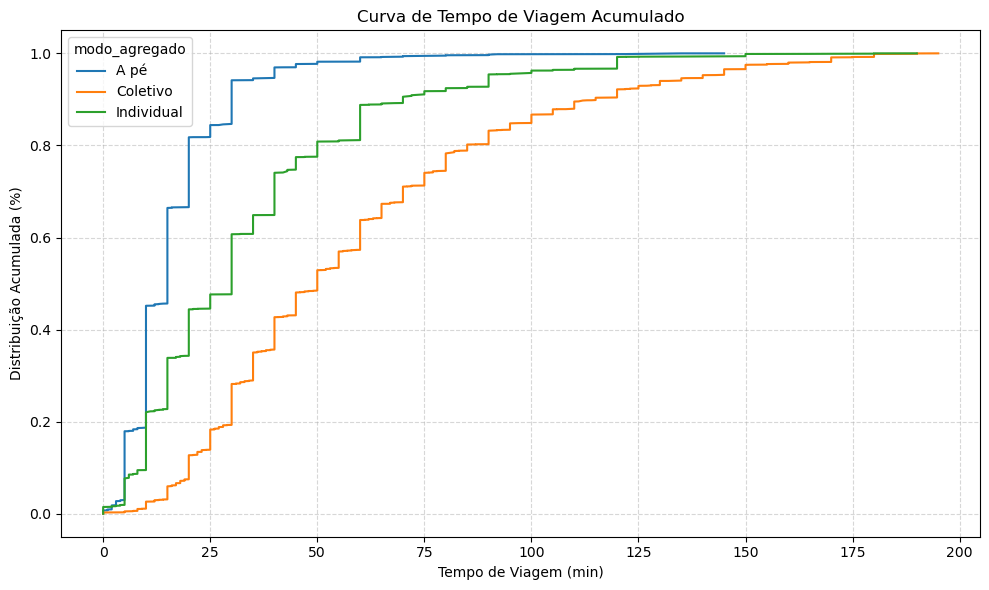

In [58]:
plot_cumulative_travel_time(hts, 'tempo_viagem', group_col='modo_agregado')

# Mapas de Calor

In [59]:
def plot_total_trips_originated(
        hts_df,
        zones_gdf,
        zone_id_col='zone_id',
        origin_col='origin_zone_id',
        weight_col='fator_expansao',
        ):
    try:
        hts_df[origin_col] = hts_df[origin_col].astype(str)
        zones_gdf[zone_id_col] = zones_gdf[zone_id_col].astype(str)

        trip_counts = (
            hts_df.groupby(origin_col)[weight_col]
            .sum()
            .rename_axis(zone_id_col)
            .reset_index(name='total_trips')
        )

        merged_gdf = zones_gdf.merge(trip_counts, on=zone_id_col, how='left')
        merged_gdf['total_trips'] = merged_gdf['total_trips'].fillna(0)

        fig, ax = plt.subplots(figsize=(10, 8))
        merged_gdf.plot(
            column='total_trips',
            cmap='viridis',
            legend=True,
            linewidth=0.3,
            edgecolor='black',
            ax=ax
        )
        ax.set_title('Total Trips Originated by Zone')
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in plot_total_trips_originated: {e}")

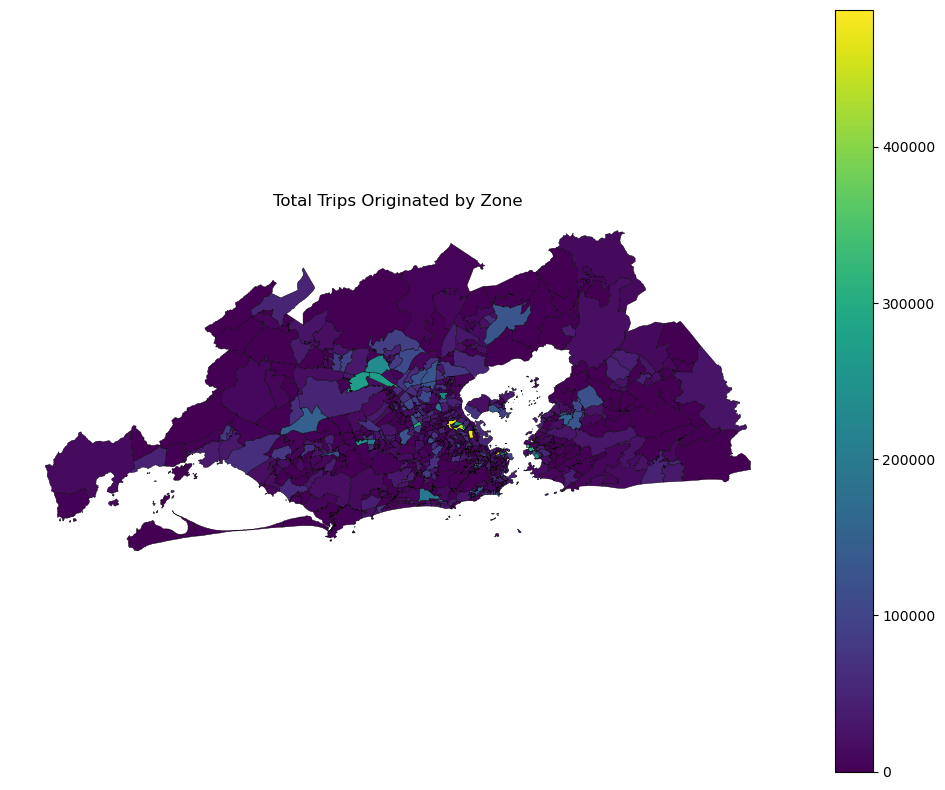

In [82]:
plot_total_trips_originated(hts, zones, zone_id_col='zona', origin_col='zona_dest')

In [80]:
def plot_avg_travel_time_by_origin(
    hts_df,
    zones_gdf,
    zone_id_col='zone_id',
    origin_col='origin_zone_id',
    time_col='travel_time_min',
    income_col=None,
    mode_col=None,
    income_filter=None,
    mode_filter=None,
    weight_col='fator_expansao'
):
    try:
        df = hts_df.copy()

        if income_col and income_filter is not None:
            df = df[df[income_col].isin(income_filter)]

        if mode_col and mode_filter is not None:
            df = df[df[mode_col].isin(mode_filter)]

        df[origin_col] = df[origin_col].astype(str)
        zones_gdf[zone_id_col] = zones_gdf[zone_id_col].astype(str)

        df = df.dropna(subset=[time_col, weight_col])

        grouped = df[[origin_col, time_col, weight_col]].groupby(origin_col, as_index=False)
        weighted_avg = grouped.apply(
            lambda g: pd.Series({
                'avg_travel_time': (g[time_col] * g[weight_col]).sum() / g[weight_col].sum()
            }),
            include_groups=False,
        ).reset_index()

        weighted_avg = weighted_avg.rename(columns={origin_col: zone_id_col})

        merged_gdf = zones_gdf.merge(weighted_avg, on=zone_id_col, how='left')
        merged_gdf['avg_travel_time'] = merged_gdf['avg_travel_time'].fillna(0)

        fig, ax = plt.subplots(figsize=(10, 8))
        merged_gdf.plot(
            column='avg_travel_time',
            cmap='YlOrRd',
            legend=True,
            linewidth=0.3,
            edgecolor='black',
            ax=ax
        )
        title = 'Average Travel Time by Origin Zone'
        if income_filter:
            title += f" - Income: {', '.join(map(str, income_filter))}"
        if mode_filter:
            title += f" - Mode: {', '.join(map(str, mode_filter))}"
        ax.set_title(title + ' (minutes)')
        ax.axis('off')
        plt.tight_layout()
        plt.show()

    except KeyError as e:
        print(f"Missing column: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")

C:\Users\brand\AppData\Local\Temp\ipykernel_5500\2690788667.py:30: RuntimeWarning: invalid value encountered in scalar divide
  'avg_travel_time': (g[time_col] * g[weight_col]).sum() / g[weight_col].sum()


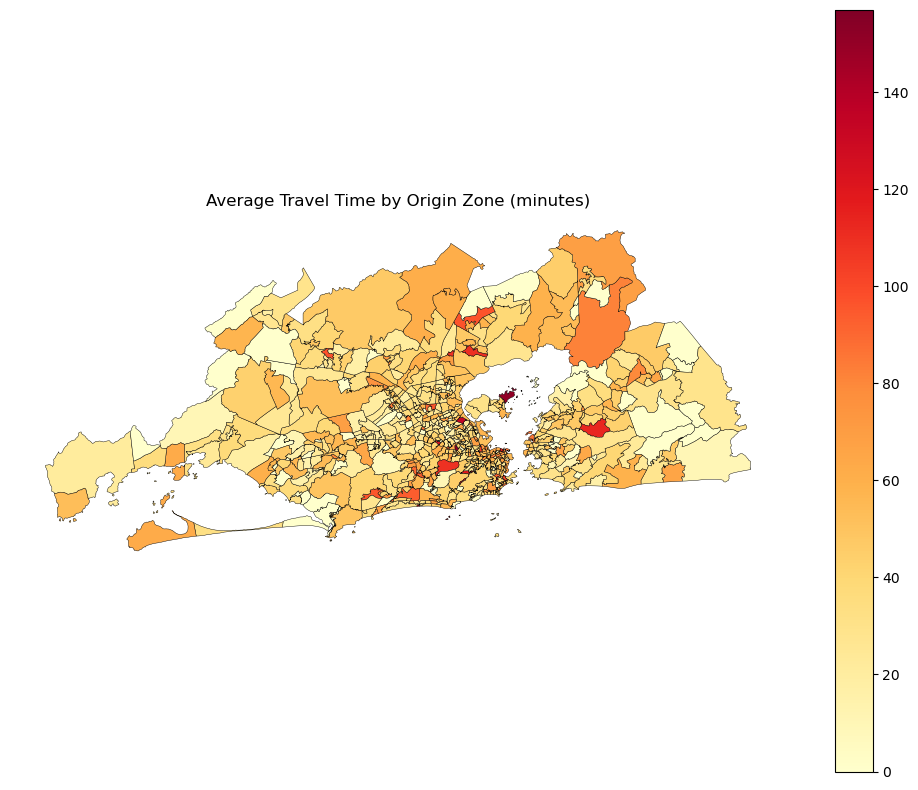

In [81]:
plot_avg_travel_time_by_origin(
    hts,
    zones,
    zone_id_col='zona',
    origin_col='zona_orig',
    time_col='tempo_viagem',
    )

## Fluxos de viagens

Analisar os fluxos de viagens de uma pesquisa OD permite entender os padrões de movimento das pessoas entre diferentes áreas de uma cidade ou região, como é o caso desta pesquisa. Essa análise identifica quais são as rotas mais utilizadas, os principais pontos de origem e destino e como esses fluxos variam ao longo do tempo.

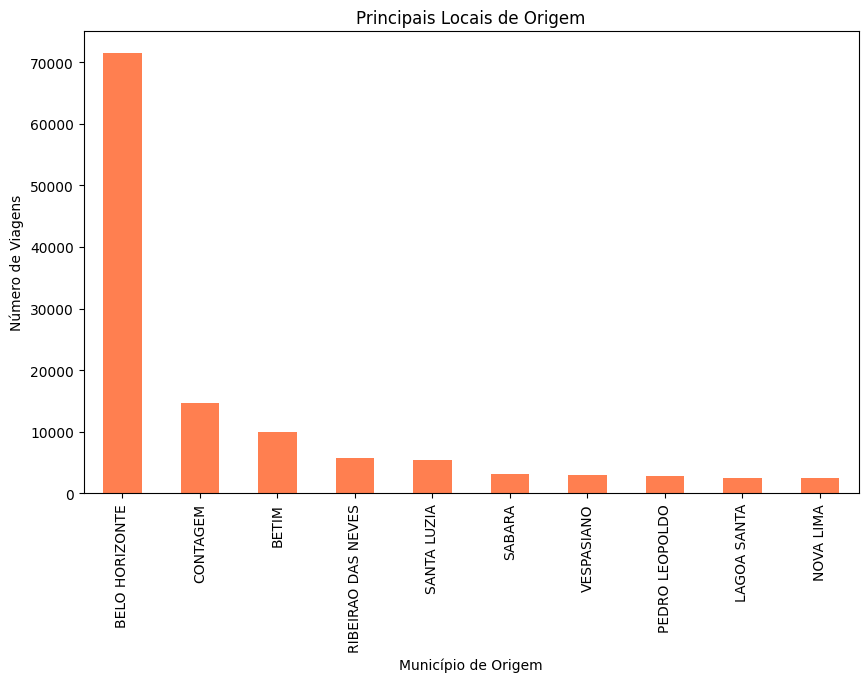

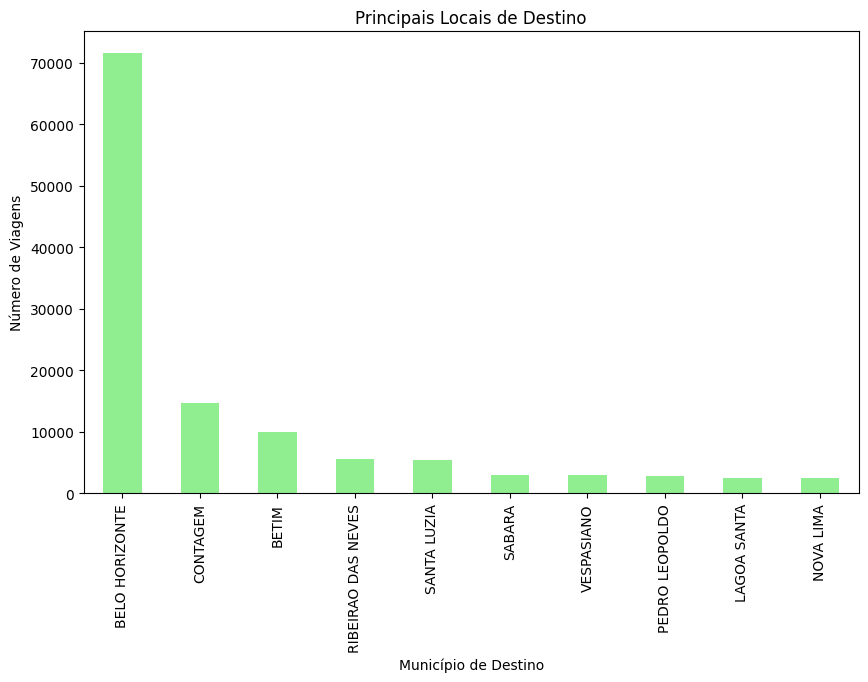

In [ ]:
# Locais de maior fluxo
fluxo_origem = df['Município origem'].value_counts()
fluxo_destino = df['Município destino'].value_counts()

# Visualização dos principais fluxos
fluxo_origem.head(10).plot(kind='bar', color='coral', figsize=(10, 6))
plt.title('Principais Locais de Origem')
plt.xlabel('Município de Origem')
plt.ylabel('Número de Viagens')
plt.show()

fluxo_destino.head(10).plot(kind='bar', color='lightgreen', figsize=(10, 6))
plt.title('Principais Locais de Destino')
plt.xlabel('Município de Destino')
plt.ylabel('Número de Viagens')
plt.show()


##Motivos da viagem

Este tipo de análise é essencial para entender as razões pelas quais as pessoas se deslocam pela cidade, e ajuda a responder a perguntas críticas sobre a demanda por transporte e como ela está distribuída entre diferentes grupos populacionais.

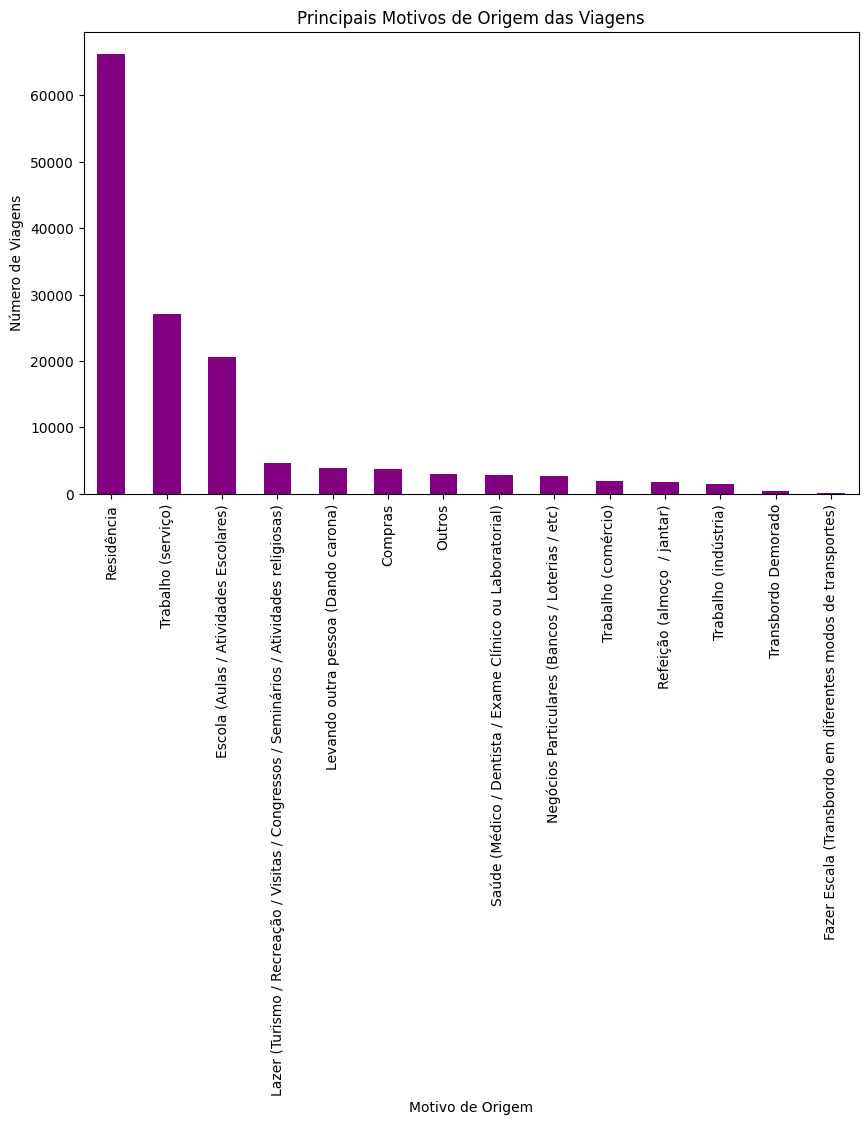

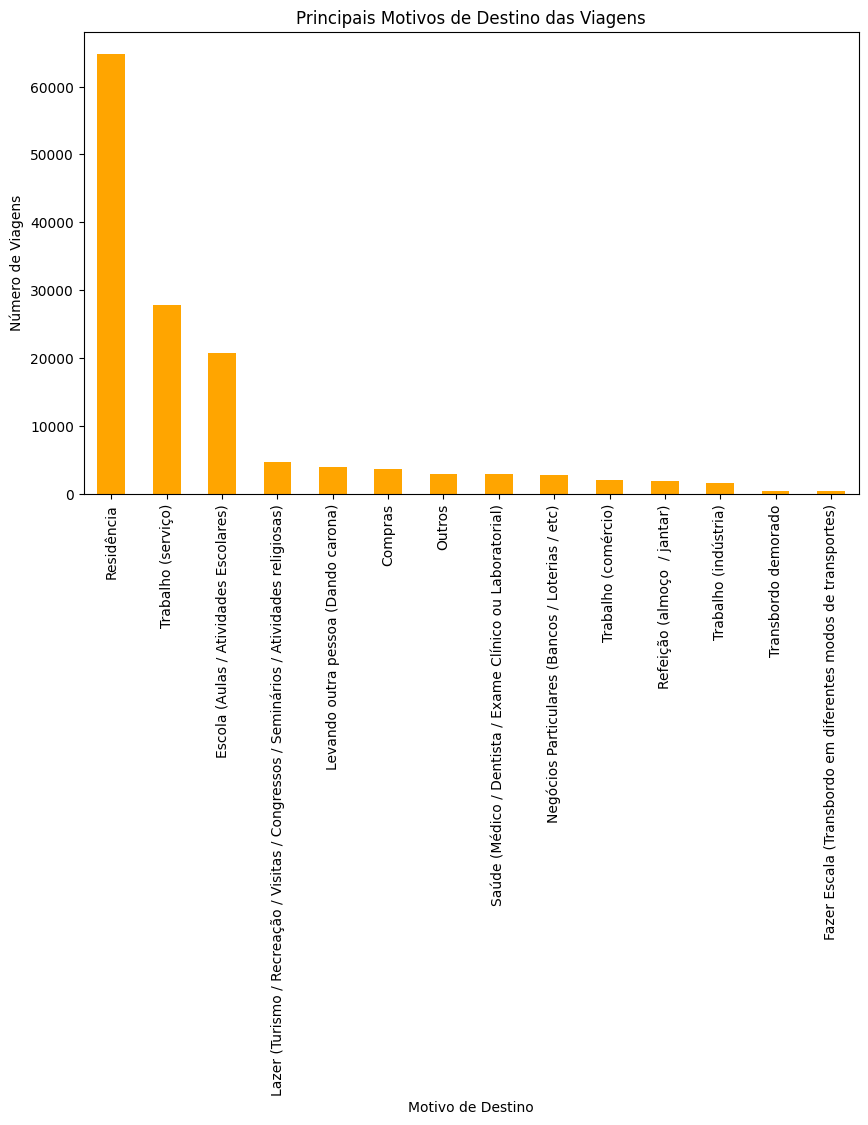

In [ ]:
# Motivos de viagem
motivos_origem = df['motivo_origem'].value_counts()
motivos_destino = df['motivo_destino'].value_counts()

# Visualização dos motivos
motivos_origem.plot(kind='bar', color='purple', figsize=(10, 6))
plt.title('Principais Motivos de Origem das Viagens')
plt.xlabel('Motivo de Origem')
plt.ylabel('Número de Viagens')
plt.show()

motivos_destino.plot(kind='bar', color='orange', figsize=(10, 6))
plt.title('Principais Motivos de Destino das Viagens')
plt.xlabel('Motivo de Destino')
plt.ylabel('Número de Viagens')
plt.show()


##Horários de pico e tempos de deslocamento

Na mobilidade urabana é fundamental entender quando ocorrem os maiores volumes de tráfego e uso de transporte público. Esses horários geralmente coincidem com os períodos em que a maioria das pessoas se desloca para o trabalho e escola e com seu retorno a casa. Compreender esses padrões é essencial para o planejamento e gestão de sistemas de transporte.

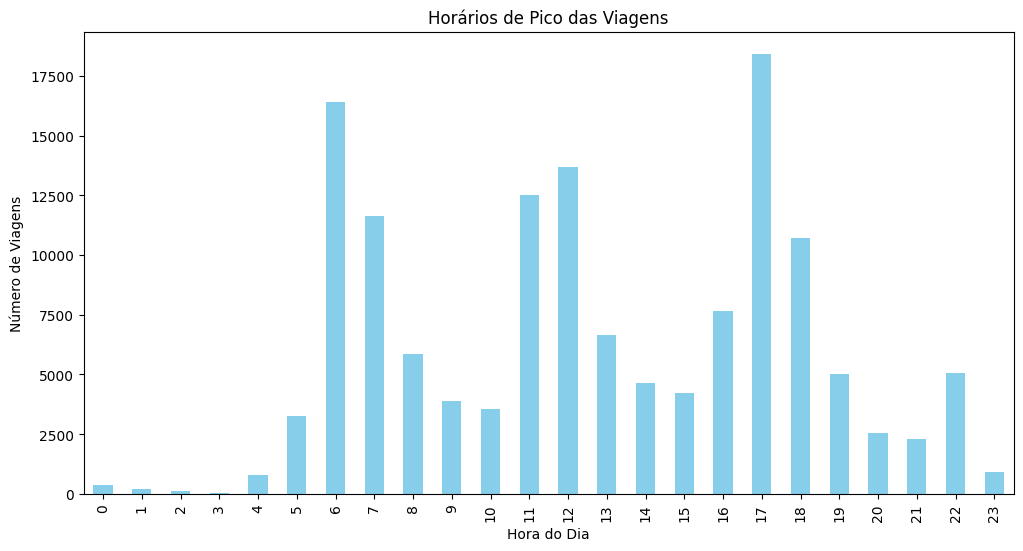

In [ ]:
# Análise de horários de pico
df['Hora início'].dt.hour.value_counts().sort_index().plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Horários de Pico das Viagens')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Viagens')
plt.show()

In [ ]:
# Verificar valores nulos nas colunas relevantes
print(df[['TEMPO DE DESLOCAMENTO', 'Renda']].isnull().sum())

# Remover registros com valores nulos nas colunas relevantes
df = df.dropna(subset=['TEMPO DE DESLOCAMENTO', 'Renda'])


TEMPO DE DESLOCAMENTO    0
Renda                    0
dtype: int64


Tempo médio de viagem: 34.01105023480859 minutos


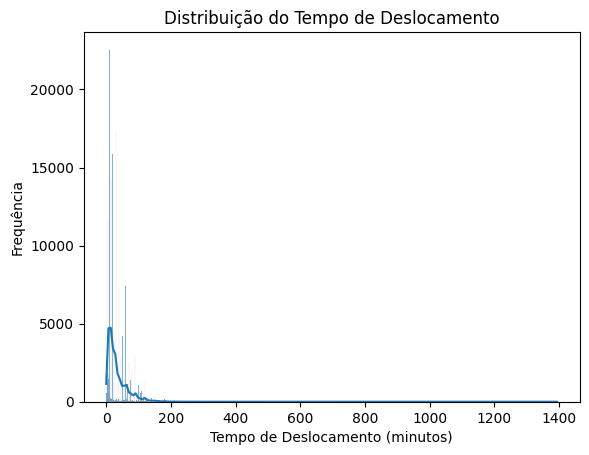

In [ ]:
# Tempo médio de viagem
mean_travel_time = df['TEMPO DE DESLOCAMENTO'].mean()
print(f'Tempo médio de viagem: {mean_travel_time} minutos')

# Visualização
sns.histplot(df['TEMPO DE DESLOCAMENTO'], kde=True)
plt.title('Distribuição do Tempo de Deslocamento')
plt.xlabel('Tempo de Deslocamento (minutos)')
plt.ylabel('Frequência')
plt.show()

##Matriz de viagem na Região Metropolitana de Belo Horizonte

A matriz origem-destino é uma ferramenta para análise de transporte e mobilidade urbana que representa os fluxos e intensidade de viagens entre diferentes zonas da cidade ou região.

In [ ]:
# Agrupando os dados por município de origem e destino e contar o número de viagens
fluxo_viagens = df.groupby(['Município origem', 'Município destino']).size().unstack(fill_value=0)

# Exibir a matriz de fluxo
fluxo_viagens.head()

Município destino,BALDIM,BELO HORIZONTE,BETIM,BRUMADINHO,CAETE,CAPIM BRANCO,CONFINS,CONTAGEM,ESMERALDAS,FLORESTAL,...,RIBEIRAO DAS NEVES,RIO ACIMA,RIO MANSO,SABARA,SANTA LUZIA,SAO JOAQUIM DE BICAS,SAO JOSE DA LAPA,SARZEDO,TAQUARACU DE MINAS,VESPASIANO
Município origem,,,,,,,,,,,,,,,,,,,,,
BALDIM,318,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BELO HORIZONTE,2,63044,695,55,51,5,38,2613,127,2,...,1144,43,1,709,887,18,75,49,6,442
BETIM,0,671,8035,19,2,0,1,860,35,2,...,14,0,7,12,7,50,1,35,0,8
BRUMADINHO,0,56,18,1412,0,0,1,13,0,0,...,2,0,4,3,1,3,0,13,0,0
CAETE,0,60,2,0,1418,0,0,4,0,0,...,0,0,0,24,1,0,0,0,6,0


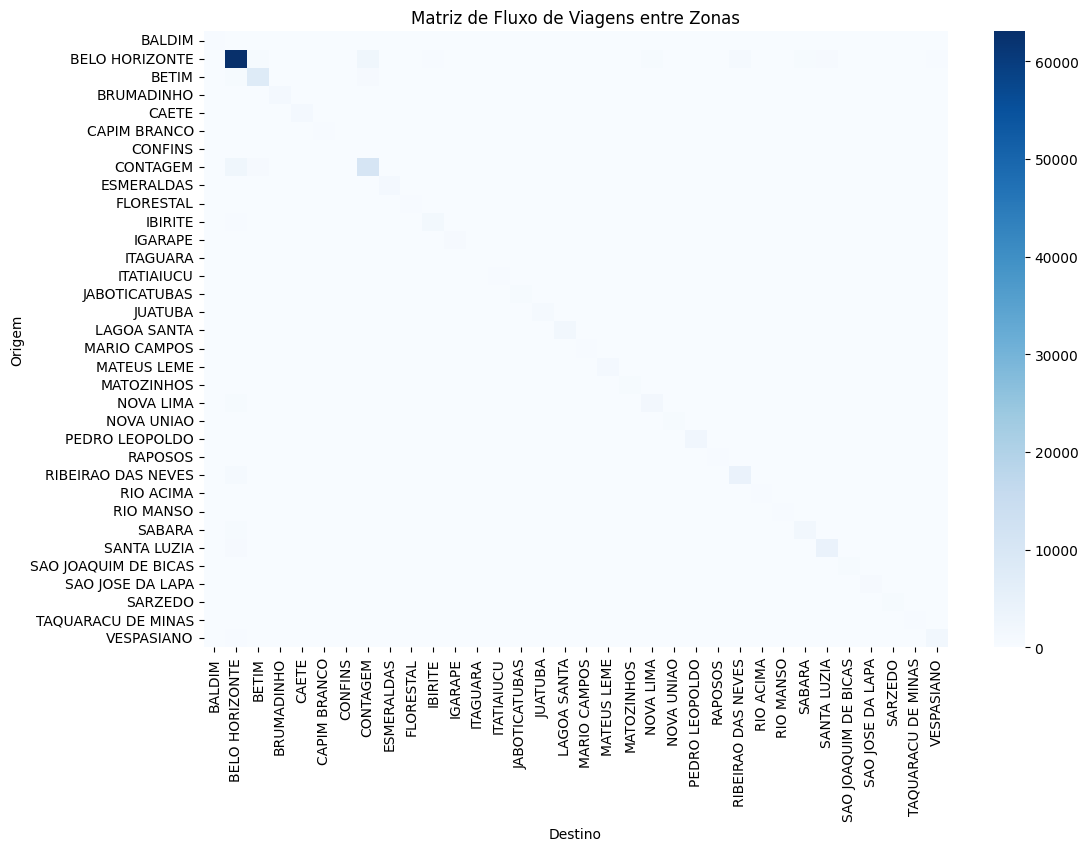

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(fluxo_viagens, cmap='Blues', annot=False, fmt='d')
plt.title('Matriz de Fluxo de Viagens entre Zonas')
plt.xlabel('Destino')
plt.ylabel('Origem')
plt.show()

In [ ]:
# Transformar a matriz de fluxo em um DataFrame para facilitar a ordenação
fluxo_viagens_df = fluxo_viagens.stack().reset_index()
fluxo_viagens_df.columns = ['Origem', 'Destino', 'Número de Viagens']

# Ordenar pelo número de viagens para identificar os principais fluxos
principais_fluxos = fluxo_viagens_df.sort_values(by='Número de Viagens', ascending=False).head(10)

# Exibir os principais fluxos
print(principais_fluxos)

                 Origem             Destino  Número de Viagens
35       BELO HORIZONTE      BELO HORIZONTE              63044
245            CONTAGEM            CONTAGEM              10662
70                BETIM               BETIM               8035
980         SANTA LUZIA         SANTA LUZIA               4286
840  RIBEIRAO DAS NEVES  RIBEIRAO DAS NEVES               4209
239            CONTAGEM      BELO HORIZONTE               2616
41       BELO HORIZONTE            CONTAGEM               2613
770      PEDRO LEOPOLDO      PEDRO LEOPOLDO               2436
945              SABARA              SABARA               2213
560         LAGOA SANTA         LAGOA SANTA               2206
